# header

In [1]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
'''

from google.colab import drive
from os import chdir

drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Gproject/MIT_glyco'
chdir(project_path)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import os
from os.path import exists
print(os.getcwd()) # current working directory

update = True

/content/drive/MyDrive/Gproject/MIT_glyco


In [3]:
load_name = "./data/data_for_ml.csv"
protein_list = list(pd.read_csv(load_name).protein.unique())
protein_augmented = [name for name in protein_list if exists(f'./data/data_for_ml(augmented)/{name}.csv')]

dataset = []
for name in protein_augmented:
    load_path = f'./data/data_for_ml(augmented)/{name}.csv'
    dataset.append(pd.read_csv(load_path))
dataset = pd.concat(dataset, axis=0).reset_index(drop=True)

positive = dataset[dataset['positivity']==1]

print("total number of proteins:          ", len(protein_list))
print("total number of augmented proteins:", len(protein_augmented))
print("total number of positive sites:    ", len(positive))

total number of proteins:           272
total number of augmented proteins: 89
total number of positive sites:     185


## parameter settings

In [4]:
from src.Data import *
from src.Preprocessing import *
from src.models import *

variables = xy_variables()
test_size = 0.2
valid_size = test_size/(1-test_size)

import random
random_state = 1
n_cv = 20

hpo_counts = 30
hpo_config = {
    "n_layers" : range(1,11),
    "n_neurons" : [16, 32, 64, 128, 256]
}
metrics = ['rnn_layers', 'rnn_neurons', 'dnn_layers', 'dnn_neurons', 
           'epoch', 'time', 'loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1']
method = "random"

# model

In [5]:
model_name = 'rnn_basic(protein_augmented)'

x_cts   = variables.x_cts_original
x_cat   = variables.x_cat_original
y_label = variables.y_label

print(f"{len(x_cts)} x_cts: {x_cts}")
print(f"{len(x_cat)} x_cat: {x_cat}")
print(f"{len(y_label)} y_label: {y_label}")

data_x, data_y = df_to_dummy(dataset, x_cts, x_cat, y_label)
display(dict(zip(range(len(data_x.columns)), data_x.columns)))

11 x_cts: ['ASA', 'Phi', 'Psi', 'Theta(i-1=>i+1)', 'Tau(i-2=>i+2)', 'HSE_alpha_up', 'HSE_alpha_down', 'P(C)', 'P(H)', 'P(E)', 'flexibility']
2 x_cat: ['SEQ', 'SS']
1 y_label: ['positivity']
dummy x shape: (59027, 34)
dummy y shape: (59027, 1)


{0: 'ASA',
 1: 'Phi',
 2: 'Psi',
 3: 'Theta(i-1=>i+1)',
 4: 'Tau(i-2=>i+2)',
 5: 'HSE_alpha_up',
 6: 'HSE_alpha_down',
 7: 'P(C)',
 8: 'P(H)',
 9: 'P(E)',
 10: 'flexibility',
 11: 'SEQ_A',
 12: 'SEQ_C',
 13: 'SEQ_D',
 14: 'SEQ_E',
 15: 'SEQ_F',
 16: 'SEQ_G',
 17: 'SEQ_H',
 18: 'SEQ_I',
 19: 'SEQ_K',
 20: 'SEQ_L',
 21: 'SEQ_M',
 22: 'SEQ_N',
 23: 'SEQ_P',
 24: 'SEQ_Q',
 25: 'SEQ_R',
 26: 'SEQ_S',
 27: 'SEQ_T',
 28: 'SEQ_V',
 29: 'SEQ_W',
 30: 'SEQ_Y',
 31: 'SS_C',
 32: 'SS_E',
 33: 'SS_H'}

In [6]:
window_size = 10

rnn_input  = []
rnn_output = []

for name in protein_augmented:
    load_path = f'./data/data_for_ml/{name}.csv'
    temp = pd.read_csv(load_path)
    temp_x, temp_y = custom_dummy(temp, x_cts, x_cat, y_label)
    
    temp_input, temp_output = data_to_sequence(temp_x, temp_y, window_size)
    rnn_input.append(temp_input)
    rnn_output.append(temp_output)
    
rnn_input  = np.concatenate(rnn_input, axis=0)
rnn_output = np.concatenate(rnn_output, axis=0)

print(f'rnn input shape : {rnn_input.shape}')
print(f'rnn output shape: {rnn_output.shape}')

rnn input shape : (8910, 21, 34)
rnn output shape: (8910, 1)


## cross validation

In [7]:
# select n_layers and n_neurons as the best values of HPO
rnn_layers = 2
rnn_neurons = 100
dnn_layers = 5
dnn_neurons = 100
cv_path = f'./result/cv_result_{model_name}_{rnn_layers}_{rnn_neurons}_{dnn_layers}_{dnn_neurons}_{n_cv}.csv'

cv_result = pd.DataFrame([], columns=metrics)
if not exists(cv_path) or update:
    for i in range(n_cv):
        print(f"\n{i+1}th iteration")
        random.seed(i+1)
        train_x, train_y, test_x, test_y, _, _ = stratified_split(rnn_input, rnn_output, 
                                                              test_size=test_size, random_state=i+1, 
                                                              scale_x=x_cts, scale_y=[])
        train_x, train_y = up_sampling(train_x, train_y)

        history_size = train_x.shape[1]
        x_dim = train_x.shape[2]
        y_dim = train_y.shape[1]
        save_path  = f'./h5/{model_name}_{rnn_layers}_{rnn_neurons}_{dnn_layers}_{dnn_neurons}_cv_{i+1}of{n_cv}.h5'

        model = RNN(history_size, x_dim, y_dim)
        model.build(rnn_layers, rnn_neurons, dnn_layers, dnn_neurons)
        if not exists(save_path) or update:
            model.train(train_x, train_y, valid_data=[test_x, test_y], save_path=save_path, verbose=2)
        else:
            model.load_model(save_path)

        epoch = model.epoch
        time = model.time
        loss = model.loss
        val_loss = model.val_loss
        test_loss, accuracy, precision, recall, f1 = model.evaluate(test_x, test_y)
        cv = pd.DataFrame([[rnn_layers, rnn_neurons, dnn_layers, dnn_neurons, epoch, time, loss, val_loss, test_loss, accuracy, 
                             precision[1], recall[1], f1[1]]], columns=metrics)
        cv_result = pd.concat([cv_result, cv], axis=0)
    cv_result = cv_result.reset_index(drop=True)
    cv_result.to_csv(cv_path, index=False)    
    
else:
    cv_result = pd.read_csv(cv_path)

display(cv_result)


1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
Epoch 1/10000
437/437 - 12s - loss: 0.5361 - accuracy: 0.7287 - val_loss: 0.4943 - val_accuracy: 0.7374 - 12s/epoch - 28ms/step
Epoch 2/10000
437/437 - 3s - loss: 0.2677 - accuracy: 0.8924 - val_loss: 0.3022 - val_accuracy: 0.9164 - 3s/epoch - 7ms/step
Epoch 3/10000
437/437 - 3s - loss: 0.1558 - accuracy: 0.9463 - val_loss: 0.2881 - val_accuracy: 0.9338 - 3s/epoch - 6ms/step
Epoch 4/10000
437/437 - 3s - loss: 0.0914 - accuracy: 0.9708 - val_loss: 0.1772 - val_accuracy: 0.9624 - 3s/epoch - 7ms/step
Epoch 5/10000
437/437 - 3s - loss: 0.0647 - accuracy: 0.9808 - val_loss: 0.2036 - val_accuracy: 0.9635 - 3s/epoch - 8ms/step
Epoch 6/10000
437/437 - 3s - loss: 0.0473 - accuracy: 0.9868 - val_loss: 0.3114 - val_accuracy: 0.9596 - 3s/epoch - 8ms/step
Epoch 7/10000
437/437 - 3s -

,rnn_layers,rnn_neurons,dnn_layers,dnn_neurons,epoch,time,loss,val_loss,test_loss,accuracy,precision,recall,f1
0,2,100,5,100,6,2.079,0.045269,0.170513,0.170513,94.05,15.15,40.54,22.06
1,2,100,5,100,38,3.690,0.005556,0.197118,0.197118,97.19,25.93,18.92,21.88
2,2,100,5,100,4,1.912,0.067153,0.225768,0.225768,96.07,22.03,35.14,27.08
3,2,100,5,100,28,3.192,0.015327,0.133465,0.133465,96.07,20.00,29.73,23.91
4,2,100,5,100,7,2.086,0.048880,0.164075,0.164075,94.95,19.54,45.95,27.42
5,2,100,5,100,2,1.796,0.155899,0.200760,0.200760,91.53,9.29,35.14,14.69
6,2,100,5,100,26,3.059,0.008318,0.156007,0.156007,97.03,28.95,29.73,29.33
7,2,100,5,100,20,2.771,0.025668,0.193610,0.193610,96.07,18.87,27.03,22.22
8,2,100,5,100,34,3.543,0.018466,0.177476,0.177476,96.63,26.53,35.14,30.23
9,2,100,5,100,33,3.442,0.004399,0.150997,0.150997,96.58,18.42,18.92,18.67



1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_1of20.h5


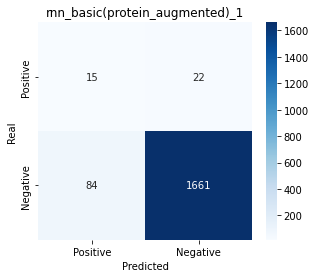

accuracy  : 94.05
precision : [98.69 15.15]
recall    : [95.19 40.54]
f1_score  : [96.91 22.06]

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_2of20.h5


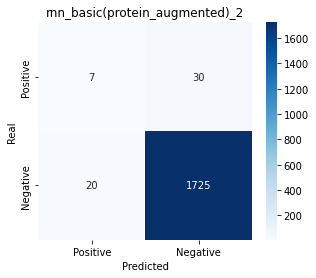

accuracy  : 97.19
precision : [98.29 25.93]
recall    : [98.85 18.92]
f1_score  : [98.57 21.88]

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_3of20.h5


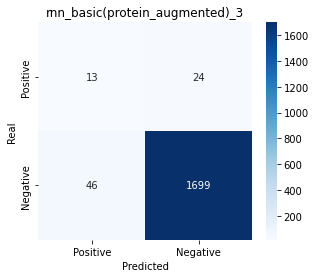

accuracy  : 96.07
precision : [98.61 22.03]
recall    : [97.36 35.14]
f1_score  : [97.98 27.08]

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0339622641509434
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_4of20.h5


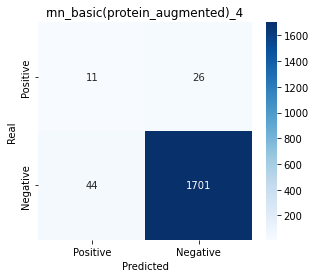

accuracy  : 96.07
precision : [98.49 20.  ]
recall    : [97.48 29.73]
f1_score  : [97.98 23.91]

5th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_5of20.h5


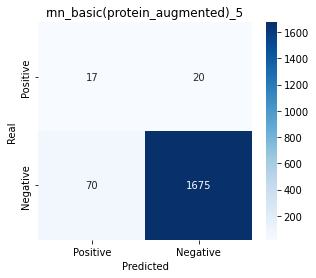

accuracy  : 94.95
precision : [98.82 19.54]
recall    : [95.99 45.95]
f1_score  : [97.38 27.42]

6th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0339622641509434
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_6of20.h5


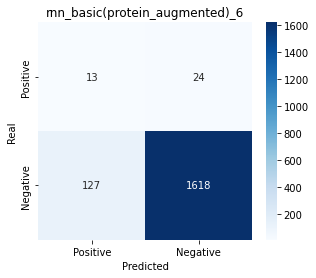

accuracy  : 91.53
precision : [98.54  9.29]
recall    : [92.72 35.14]
f1_score  : [95.54 14.69]

7th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_7of20.h5


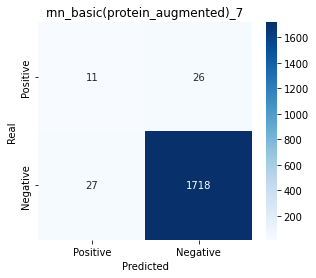

accuracy  : 97.03
precision : [98.51 28.95]
recall    : [98.45 29.73]
f1_score  : [98.48 29.33]

8th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0030864197530864
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_8of20.h5


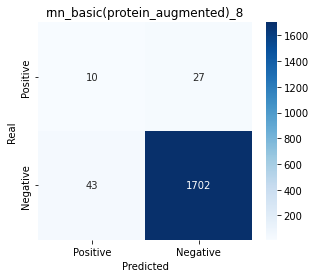

accuracy  : 96.07
precision : [98.44 18.87]
recall    : [97.54 27.03]
f1_score  : [97.99 22.22]

9th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_9of20.h5


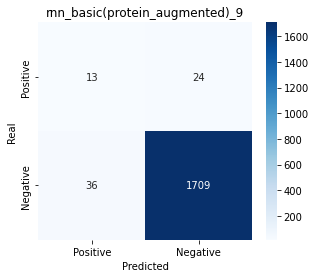

accuracy  : 96.63000000000001
precision : [98.62 26.53]
recall    : [97.94 35.14]
f1_score  : [98.27 30.23]

10th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_10of20.h5


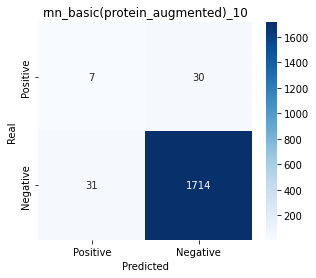

accuracy  : 96.58
precision : [98.28 18.42]
recall    : [98.22 18.92]
f1_score  : [98.25 18.67]

11th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_11of20.h5


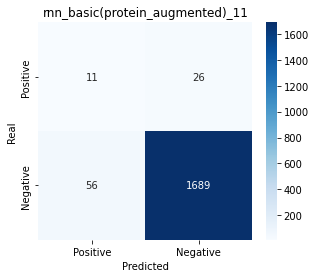

accuracy  : 95.39999999999999
precision : [98.48 16.42]
recall    : [96.79 29.73]
f1_score  : [97.63 21.15]

12th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0025929127052722
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_12of20.h5


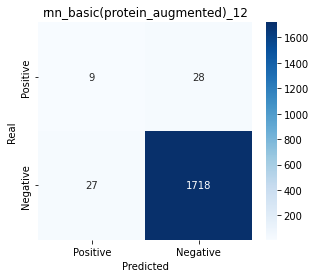

accuracy  : 96.91
precision : [98.4 25. ]
recall    : [98.45 24.32]
f1_score  : [98.42 24.66]

13th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_13of20.h5


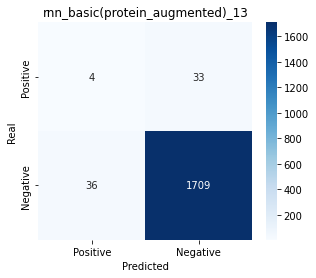

accuracy  : 96.13000000000001
precision : [98.11 10.  ]
recall    : [97.94 10.81]
f1_score  : [98.02 10.39]

14th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_14of20.h5


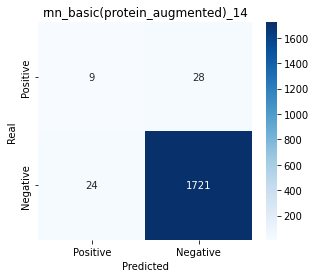

accuracy  : 97.08
precision : [98.4  27.27]
recall    : [98.62 24.32]
f1_score  : [98.51 25.71]

15th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0339622641509434
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_15of20.h5


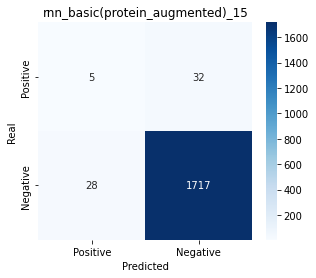

accuracy  : 96.63000000000001
precision : [98.17 15.15]
recall    : [98.4  13.51]
f1_score  : [98.28 14.29]

16th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0339622641509434
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_16of20.h5


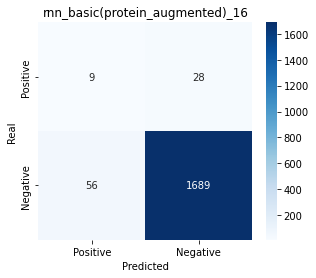

accuracy  : 95.28999999999999
precision : [98.37 13.85]
recall    : [96.79 24.32]
f1_score  : [97.57 17.65]

17th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_17of20.h5


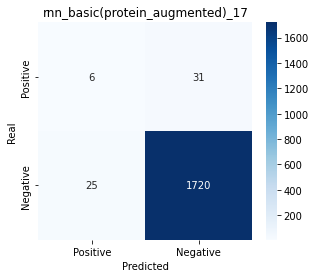

accuracy  : 96.86
precision : [98.23 19.35]
recall    : [98.57 16.22]
f1_score  : [98.4  17.65]

18th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0339622641509434
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_18of20.h5


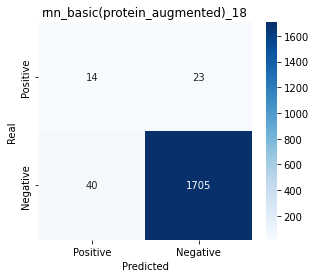

accuracy  : 96.46000000000001
precision : [98.67 25.93]
recall    : [97.71 37.84]
f1_score  : [98.19 30.77]

19th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_19of20.h5


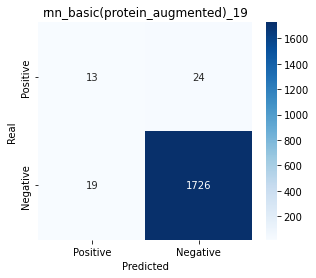

accuracy  : 97.59
precision : [98.63 40.62]
recall    : [98.91 35.14]
f1_score  : [98.77 37.68]

20th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 34) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 34) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 21, 34) (13960, 1)
model has been restored from ./h5/rnn_basic(protein_augmented)_2_100_5_100_cv_20of20.h5


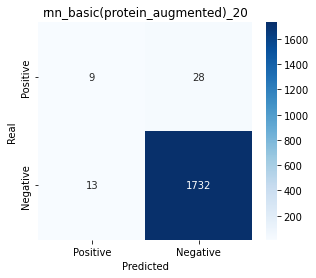

accuracy  : 97.7
precision : [98.41 40.91]
recall    : [99.26 24.32]
f1_score  : [98.83 30.51]


In [8]:
from src.graph_plot import *

for i in range(n_cv):
    print(f"\n{i+1}th iteration")
    random.seed(i+1)
    train_x, train_y, test_x, test_y, _, _ = stratified_split(rnn_input, rnn_output, 
                                                          test_size=test_size, random_state=i+1, 
                                                          scale_x=x_cts, scale_y=[])
    train_x, train_y = up_sampling(train_x, train_y)

    history_size = train_x.shape[1]
    x_dim = train_x.shape[2]
    y_dim = train_y.shape[1]
    save_path  = f'./h5/{model_name}_{rnn_layers}_{rnn_neurons}_{dnn_layers}_{dnn_neurons}_cv_{i+1}of{n_cv}.h5'

    model = RNN(history_size, x_dim, y_dim)
    model.build(rnn_layers, rnn_neurons, dnn_layers, dnn_neurons)
    model.load_model(save_path)
    
    prediction = model.model.predict(test_x, verbose=0)
    y_pred = prediction.round(0).astype(int)
    y_real = test_y
    
    plot_confusion(y_real, y_pred, title=model_name+f"_{i+1}", label=["Positive","Negative"])